<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Diego Alberto López Lazareno, Andrea Flores Fernández.

**Fecha:** 24 de noviembre del 2021.

**Expediente** : 722100, 725449.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/diegolazareno/Tarea9_DALopez_AFlores

# Tarea 9: Clase 23

## Enunciado de tarea 

Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:

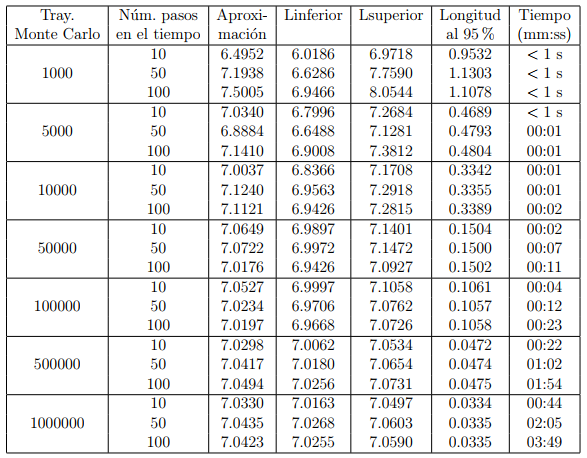

Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

### Ejercicio 1

`Estudiante 1 : Diego`

In [1]:
# Librerías necesarias
import pandas as pd
import numpy as np
import datetime
import scipy.stats as st

# Funciones
def priceSimulations(mu, sigma, S0, trajectories, steps):
    """
    priceSimulations retorna St, una matriz con la simulación de precios para un activo financiero.
    
    *mu : es la tasa libre de riesgo (anualizada).
    *sigma : es la volatilidad del subyacente (anualizada).
    *S0 : es el precio inicial del subyacente.
    *trajectories : es el número de trayectorias a simular.
    *steps : es el número de pasos o días a simular.
    
    """
    deltaT = 1 / steps
    increments = (mu - sigma ** 2 / 2) * deltaT + sigma * np.random.randn(steps - 1, trajectories) * np.sqrt(deltaT) 
    St = np.exp(np.concatenate([np.log(S0) * np.ones([1, trajectories]), increments], axis = 0).cumsum(axis = 0))
    
    return pd.DataFrame(St)

def RiemannSums(mu, sigma, S0, trajectories, steps, K, optionType):
    """
    RiemannSums valúa una opción del tipo euroasiática por el método de las sumas de Riemann.
    
    *mu : es la tasa libre de riesgo (anualizada).
    *sigma : es la volatilidad del subyacente (anualizada).
    *S0 : es el precio inicial del subyacente.
    *trajectories : es el número de trayectorias a simular.
    *steps : es el número de pasos o días a simular.
    *K : es el precio de ejercicio.
    *optionType : es el tipo de opción a valuar, Call o Put.
    
    """
    t0 = datetime.datetime.now()
    St = priceSimulations(mu, sigma, S0, trajectories, steps)
    average_St = St.expanding().mean()
    
    # Valuación Call
    if optionType == "Call":
        optionPrice = np.exp(-mu) * np.fmax(average_St - K, 0).mean(axis = 1)
        
    # Valuación Put
    else:
        optionPrice = np.exp(-mu) * np.fmax(K - average_St, 0).mean(axis = 1)
    
    confidenceInterval = st.norm.interval(0.95, loc = optionPrice.iloc[-1], scale = st.sem(optionPrice))
    
    t1 = datetime.datetime.now() - t0
    if t1.seconds < 1:
        t1 = str("<1s")
    else:
        t1 = str(t1)[2 : 7]

    
    return optionPrice.iloc[-1], confidenceInterval[0], confidenceInterval[1], confidenceInterval[1] - confidenceInterval[0], t1
    
def Trapezoid(mu, sigma, S0, trajectories, steps, K, optionType):
    """
    Trapezoid valúa una opción del tipo euroasiática por el esquema del trapecio.
    
    *mu : es la tasa libre de riesgo (anualizada).
    *sigma : es la volatilidad del subyacente (anualizada).
    *S0 : es el precio inicial del subyacente.
    *trajectories : es el número de trayectorias a simular.
    *steps : es el número de pasos o días a simular.
    *K : es el precio de ejercicio.
    *optionType : es el tipo de opción a valuar, Call o Put.
    
    """
    t0 = datetime.datetime.now()
    St = priceSimulations(mu, sigma, S0, trajectories, steps)
    average_St = ((St * (2 + mu * (1 / steps) + np.random.randn(steps, trajectories) * sigma)).cumsum()) * (1 / (2 * steps))
    
    # Valuación Call
    if optionType == "Call":
        optionPrice = np.exp(-mu) * np.fmax(average_St - K, 0).mean(axis = 1)
        
    # Valuación Put
    else:
        optionPrice = np.exp(-mu) * np.fmax(K - average_St, 0).mean(axis = 1)
    
    confidenceInterval = st.norm.interval(0.95, loc = optionPrice.iloc[-1], scale = st.sem(optionPrice))
    
    t1 = datetime.datetime.now() - t0
    if t1.seconds < 1:
        t1 = str("<1s")
    else:
        t1 = str(t1)[2 : 7]

    
    return optionPrice.iloc[-1], confidenceInterval[0], confidenceInterval[1], confidenceInterval[1] - confidenceInterval[0], t1
    

In [2]:
# Parámetros iniciales 
mu = 0.10 # Tasa libre de riesgo anualizada
sigma = 0.20 # Volatilidad anualizada
S0 = 100 # Precio inicial
K = 100 # Precio de ejercicio de la opción
NSteps = [10, 50, 100] # Número de pasos
Ntrajectories = [1000, 5000, 10000, 50000, 100000, 500000, 1000000] # Número de trayectorias
#Ntrajectories = [1000, 5000, 10000, 50000] # Número de trayectorias
index = pd.MultiIndex.from_product([Ntrajectories, NSteps], names = ["Tray. Monte Carlo", "Núm. pasos en el tiempo"]) # Índice
cols = ["Aproximación", "Linferior", "Lsuperior", "Longitud al 95%", "Tiempo (mm:ss)"] # Columnas

## Valuación por Sumas de Riemann

### Call 

In [3]:
results1 = []
[[results1.append(RiemannSums(mu, sigma, S0, j, i, K, "Call")) for i in NSteps] for j in Ntrajectories];
callRiemann = pd.DataFrame(results1, index = index, columns = cols)
callRiemann

Aproximación  Linferior  Lsuperior  \
Tray. Monte Carlo Núm. pasos en el tiempo                                       
1000              10                           6.926327   5.551386   8.301267   
                  50                           7.127666   6.590954   7.664378   
                  100                          7.333076   6.948611   7.717542   
5000              10                           6.414167   5.147232   7.681102   
                  50                           6.871229   6.356961   7.385498   
                  100                          6.732165   6.387268   7.077062   
10000             10                           6.385098   5.122059   7.648137   
                  50                           6.957270   6.439094   7.475446   
                  100                          6.887928   6.536365   7.239492   
50000             10                           6.397990   5.129070   7.666910   
                  50                           6.901804   6.386080   7.417528   
                  100                          6.924398   6.568616   7.280179   
100000            10                           6.404384   5.134623   7.674146   
                  50                           6.921852   6.405987   7.437718   
                  100                          6.979546   6.619745   7.339347   
500000            10                           6.425890   5.151973   7.699808   
                  50                           6.910185   6.394158   7.426212   
                  100                          6.999866   6.639068   7.360664   
1000000           10                           6.416358   5.144826   7.687890   
                  50                           6.925867   6.408679   7.443055   
                  100                          6.985709   6.625614   7.345803   

                                           Longitud al 95% Tiempo (mm:ss)  
Tray. Monte Carlo Núm. pasos en el tiempo                                  
1000              10                              2.749881            <1s  
                  50                              1.073424            <1s  
                  100                             0.768931            <1s  
5000              10                              2.533870            <1s  
                  50                              1.028537            <1s  
                  100                             0.689794            <1s  
10000             10                              2.526078            <1s  
                  50                              1.036352            <1s  
                  100                             0.703127            <1s  
50000             10                              2.537840          00:03  
                  50                              1.031448          00:03  
                  100                             0.711563          00:04  
100000            10                              2.539523          00:06  
                  50                              1.031731          00:06  
                  100                             0.719602          00:07  
500000            10                              2.547835          00:31  
                  50                              1.032053          00:35  
                  100                             0.721595          00:39  
1000000           10                              2.543064          00:51  
                  50                              1.034377          00:50  
                  100                             0.720190          00:53

### Put

In [4]:
results2 = []
[[results2.append(RiemannSums(mu, sigma, S0, j, i, K, "Put")) for i in NSteps] for j in Ntrajectories];
putRiemann = pd.DataFrame(results2, index = index, columns = cols)
putRiemann

Aproximación  Linferior  Lsuperior  \
Tray. Monte Carlo Núm. pasos en el tiempo                                       
1000              10                           2.288683   1.842407   2.734959   
                  50                           2.270584   2.124622   2.416546   
                  100                          2.469420   2.359900   2.578941   
5000              10                           2.248011   1.813060   2.682962   
                  50                           2.330521   2.183027   2.478015   
                  100                          2.343273   2.243600   2.442946   
10000             10                           2.174362   1.755068   2.593656   
                  50                           2.382864   2.231769   2.533960   
                  100                          2.285231   2.189492   2.380970   
50000             10                           2.244695   1.814223   2.675166   
                  50                           2.323241   2.176676   2.469805   
                  100                          2.341929   2.242249   2.441609   
100000            10                           2.227098   1.800852   2.653345   
                  50                           2.335988   2.187562   2.484414   
                  100                          2.370205   2.269069   2.471341   
500000            10                           2.220041   1.794430   2.645652   
                  50                           2.328832   2.180986   2.476677   
                  100                          2.338002   2.238658   2.437346   
1000000           10                           2.223296   1.797181   2.649412   
                  50                           2.330253   2.182397   2.478109   
                  100                          2.346830   2.247147   2.446514   

                                           Longitud al 95% Tiempo (mm:ss)  
Tray. Monte Carlo Núm. pasos en el tiempo                                  
1000              10                              0.892552            <1s  
                  50                              0.291923            <1s  
                  100                             0.219041            <1s  
5000              10                              0.869901            <1s  
                  50                              0.294988            <1s  
                  100                             0.199346            <1s  
10000             10                              0.838588            <1s  
                  50                              0.302191            <1s  
                  100                             0.191479            <1s  
50000             10                              0.860943          00:02  
                  50                              0.293129          00:02  
                  100                             0.199360          00:02  
100000            10                              0.852493          00:04  
                  50                              0.296852          00:04  
                  100                             0.202273          00:05  
500000            10                              0.851222          00:21  
                  50                              0.295691          00:23  
                  100                             0.198688          00:29  
1000000           10                              0.852231          00:42  
                  50                              0.295712          00:53  
                  100                             0.199367          01:07

## Valuación por Esquema del Trapecio

### Call

In [5]:
results3 = []
[[results3.append(Trapezoid(mu, sigma, S0, j, i, K, "Call")) for i in NSteps] for j in Ntrajectories];
callTrapezoid = pd.DataFrame(results3, index = index, columns = cols)
callTrapezoid

Aproximación  Linferior  Lsuperior  \
Tray. Monte Carlo Núm. pasos en el tiempo                                       
1000              10                           6.429664   5.169591   7.689737   
                  50                           6.919396   6.515153   7.323639   
                  100                          7.242008   6.956978   7.527037   
5000              10                           6.898493   5.546046   8.250940   
                  50                           7.116317   6.695511   7.537123   
                  100                          6.862615   6.593439   7.131792   
10000             10                           6.909089   5.553601   8.264578   
                  50                           7.031346   6.615557   7.447136   
                  100                          7.067817   6.789266   7.346369   
50000             10                           6.902363   5.548747   8.255979   
                  50                           6.975686   6.563731   7.387641   
                  100                          7.012042   6.736401   7.287683   
100000            10                           6.880579   5.531141   8.230017   
                  50                           6.976614   6.564994   7.388234   
                  100                          7.004459   6.729370   7.279549   
500000            10                           6.909297   5.554228   8.264367   
                  50                           7.033743   6.618286   7.449200   
                  100                          7.031614   6.755103   7.308126   
1000000           10                           6.895709   5.543319   8.248098   
                  50                           7.011721   6.597825   7.425617   
                  100                          7.012780   6.737099   7.288460   

                                           Longitud al 95% Tiempo (mm:ss)  
Tray. Monte Carlo Núm. pasos en el tiempo                                  
1000              10                              2.520146            <1s  
                  50                              0.808486            <1s  
                  100                             0.570059            <1s  
5000              10                              2.704894            <1s  
                  50                              0.841612            <1s  
                  100                             0.538353            <1s  
10000             10                              2.710977            <1s  
                  50                              0.831579            <1s  
                  100                             0.557103            <1s  
50000             10                              2.707232            <1s  
                  50                              0.823910            <1s  
                  100                             0.551283            <1s  
100000            10                              2.698876            <1s  
                  50                              0.823240          00:01  
                  100                             0.550179          00:01  
500000            10                              2.710139          00:02  
                  50                              0.830914          00:05  
                  100                             0.553023          00:10  
1000000           10                              2.704778          00:04  
                  50                              0.827792          00:12  
                  100                             0.551360          00:21

### Put

In [6]:
results4 = []
[[results4.append(Trapezoid(mu, sigma, S0, j, i, K, "Put")) for i in NSteps] for j in Ntrajectories];
putTrapezoid = pd.DataFrame(results4, index = index, columns = cols)
putTrapezoid

Aproximación  Linferior  Lsuperior  \
Tray. Monte Carlo Núm. pasos en el tiempo                                       
1000              10                           2.353857 -14.716292  19.424006   
                  50                           2.505673  -4.922011   9.933357   
                  100                          2.288520  -2.979830   7.556870   
5000              10                           2.224036 -14.883160  19.331232   
                  50                           2.323620  -5.141661   9.788901   
                  100                          2.376215  -2.883871   7.636301   
10000             10                           2.223922 -14.880407  19.328251   
                  50                           2.375037  -5.087438   9.837512   
                  100                          2.361734  -2.900455   7.623924   
50000             10                           2.232238 -14.879214  19.343691   
                  50                           2.352591  -5.105432   9.810614   
                  100                          2.337188  -2.921489   7.595865   
100000            10                           2.229254 -14.887296  19.345805   
                  50                           2.353610  -5.104352   9.811572   
                  100                          2.340018  -2.917449   7.597485   
500000            10                           2.219795 -14.898039  19.337629   
                  50                           2.330093  -5.132253   9.792440   
                  100                          2.352785  -2.904231   7.609802   
1000000           10                           2.221871 -14.894781  19.338523   
                  50                           2.327366  -5.135890   9.790621   
                  100                          2.343505  -2.914501   7.601511   

                                           Longitud al 95% Tiempo (mm:ss)  
Tray. Monte Carlo Núm. pasos en el tiempo                                  
1000              10                             34.140298            <1s  
                  50                             14.855368            <1s  
                  100                            10.536700            <1s  
5000              10                             34.214392            <1s  
                  50                             14.930562            <1s  
                  100                            10.520172            <1s  
10000             10                             34.208658            <1s  
                  50                             14.924951            <1s  
                  100                            10.524379            <1s  
50000             10                             34.222905            <1s  
                  50                             14.916047            <1s  
                  100                            10.517355          00:01  
100000            10                             34.233102            <1s  
                  50                             14.915924          00:01  
                  100                            10.514934          00:02  
500000            10                             34.235668          00:02  
                  50                             14.924693          00:06  
                  100                            10.514033          00:10  
1000000           10                             34.233304          00:05  
                  50                             14.926511          00:12  
                  100                            10.516012          00:21

## Conclusión

Al hacer la valuación de la opción call y put asiáticas llegamos a que el método del esquema del trapecio es el que genera mejores resultados a comparación de las sumas de Riemann, pues esta primera metodología converge más rápidamente (es decir, en menos trayectorias) a los precios de ambas opciones (que son proporcionados por el profesor). Igualmente se comprueba que la valuación a través del esquema del trapecio es más eficiente, pues cuando se aumentan considerablemente las trayectorias tarda un tiempo considerablemente menor a comparación de las sumas de Riemann. El único inconveniente que presenta esta metodología es que para el caso del put asiático, en el límite inferior del intervalo de confianza, da valores negativos para la prima.

`Estudiante 2 : Andrea`

In [7]:
#Importar las librerías necesarias:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
%matplotlib inline
#Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)
# Datos escenario: 
np.random.seed(5555)
S0 = 100; K = 100 ; r = 0.10
sigma = 0.20; T = 1 ;p = 7.04
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]

In [8]:
#b&s:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    nu = (mu-(sigma**2)/2)
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    LogSt = np.cumsum(concat,axis=1)
    St = np.exp(LogSt)
    t = np.arange(0,NbStep)
    return St.T,t
#Daily ret:
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [9]:
#Método trapecio:
#Para put:
def trapecio_p(K,r,S0,NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:"put o call"=None):
    start = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t)
    strike = K
    h = T/NbStep
    formula = (2+r*h+np.random.randn(NbStep,NbTraj)*sigma)
    av1 = np.cumsum(prices*(formula))
    av2 = h/(2*T)
    Average_t = av1*av2
    strike = K
    #si es put:
    if tipo == "put":
        put_opt = pd.DataFrame({"Prima":np.exp(-r*T)*np.fmax(strike-Average_t,0).mean(axis=1)},index=t)
    else:
        put_opt = pd.DataFrame({"Prima":np.exp(-r*T)*np.fmax(Average_t-strike,0).mean(axis=1)},index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put_opt.sem().Prima
    mean_est = put_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza,loc=mean_est,scale=sigma_est)
    distance = (i1[1]-i1[0])
    distance2 = np.round(distance,4)
    end = time.time()
    time_dif = int(end-start)
    timef = '{:02d}:{:02d}'.format((time_dif%3600//60),time_dif%60)
    total_time = lambda x: '< 1 s'if x=='00:00' else x #también es para el formato
    il0=np.round(i1[0],4)
    il1=np.round(i1[1],4)
    res = np.array([np.round(put_opt.iloc[-1].Prima,4),il0,il1,distance2,total_time(timef)])
    return res

In [10]:
#Mapeo put trapecio: 
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]
trap_p =  np.array(list(map(lambda N_traj:list(map(lambda N_step:trapecio_p(K,r,S0,N_traj,N_step,sigma,T,"put"),NbStep)),NbTraj)))
num = (0, 1, 2)
pd.set_option("display.max_rows", None, "display.max_columns", None)
ciclo =[i for i in NbTraj for _ in num]
rs = np.array(list(map(lambda i: trap_p[:,:,i].flatten(),range(5))))
rs0 = np.round(rs[0].astype('float'),4)
rs1 = np.round(rs[1].astype('float'),4)
rs2 = np.round(rs[2].astype('float'),4)
rs3 = np.round(rs[3].astype('float'),4)
listas = [ciclo,(len(NbTraj)*NbStep),rs0,rs1,rs2,rs3,rs[4]]
index = pd.MultiIndex.from_arrays(listas,names=('Tray.Monte Carlo','Núm.Pasos en el tiempo','Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))
df_trapecio_p = pd.DataFrame(index=index)

In [11]:
#Para call:
def trapecio_c(K,r,S0,NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:"put o call"=None):
    start = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t)
    strike = K
    h = (T/NbStep)
    formula = (2+r*h+np.random.randn(NbStep,NbTraj)*sigma)
    Av1 = np.cumsum(prices*(formula))
    Av2 = h/(2*T)
    Average_t = Av1*Av2
    strike = K
    #si es call:
    if tipo == "call":
        call_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(Average_t-strike,0).mean(axis=1)},index=t)
    else:
        call_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(strike-Average_t,0).mean(axis=1)},index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call_opt.sem().Prima
    mean_est = call_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza,loc=mean_est,scale=sigma_est)
    distance = (i1[1]-i1[0])
    distance2 = np.round(distance,4)
    end = time.time()
    time_dif = int(end - start)
    timef = '{:02d}:{:02d}'.format((time_dif%3600//60),time_dif%60)
    total_time = (lambda x: '< 1 s' if x=='00:00' else x)
    il0 = np.round(i1[0],4)
    il1 = np.round(i1[1],4)
    res = np.array([np.round(call_opt.iloc[-1].Prima,4),il0,il1,distance2,total_time(timef)])
    return res
#Mapeo call trapecio: 
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]
trap_c=np.array(list(map(lambda N_traj:list(map(lambda N_step: trapecio_c(K,r,S0,N_traj,N_step,sigma,T,"call"),NbStep)),NbTraj)))
num = (0, 1, 2)
pd.set_option("display.max_rows", None, "display.max_columns", None)
ciclo =[i for i in NbTraj for _ in num]
rs = np.array(list(map(lambda i: trap_c[:,:,i].flatten(),range(5))))
rs0 = np.round(rs[0].astype('float'),4)
rs1 = np.round(rs[1].astype('float'),4)
rs2 = np.round(rs[2].astype('float'),4)
rs3 = np.round(rs[3].astype('float'),4)
listas = [ciclo,(len(NbTraj)*NbStep),rs0,rs1,rs2,rs3,rs[4]]
index = pd.MultiIndex.from_arrays(listas, names=('Tray.Monte Carlo','Núm.Pasos en el tiempo','Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))
df_trapecio_c = pd.DataFrame(index=index)

In [12]:
#Método Riemann
#Función de clase adaptada para put:
def riemann_p(K,r,S0,NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:"put o call"=None):
    start = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t)
    Average_t = prices.expanding().mean()
    strike = K
    #si es put:
    if tipo == "put":
        put_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(strike-Average_t,0).mean(axis=1)},index=t)
    else:
        put_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(Average_t-strike,0).mean(axis=1)},index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = put_opt.sem().Prima
    mean_est = put_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza,loc=mean_est,scale=sigma_est)
    il0 = np.round(i1[0],4)
    il1 = np.round(i1[1],4)
    distance = np.round(i1[1] - i1[0],4)
    distance2 = np.round(distance,4)
    end = time.time()
    time_dif = int(end - start)
    timef = '{:02d}:{:02d}'.format((time_dif%3600//60),time_dif%60)
    total_time = lambda x: '< 1 s' if x=='00:00' else x
    res = np.array([np.round(put_opt.iloc[-1].Prima,4),il0,il1,distance2,total_time(timef)])
    return res
# Mapeo Riemann para put:
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]
ri_p =  np.array(list(map(lambda N_traj:list(map(lambda N_step:riemann_p(K,r,S0,N_traj,N_step,sigma,T,'put'),NbStep)),NbTraj)))
num = (0, 1, 2)
pd.set_option("display.max_rows", None, "display.max_columns", None)
ciclo =[i for i in NbTraj for _ in num]
rs = np.array(list(map(lambda i: ri_p[:,:,i].flatten(),range(5))))
rs0 = np.round(rs[0].astype('float'),4)
rs1 = np.round(rs[1].astype('float'),4)
rs2 = np.round(rs[2].astype('float'),4)
rs3 = np.round(rs[3].astype('float'),4)
listas = [ciclo,(len(NbTraj)*NbStep),rs0,rs1,rs2,rs3,rs[4]]
index = pd.MultiIndex.from_arrays(listas, names=('Tray.Monte Carlo','Núm.Pasos en el tiempo','Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))
df_riemann_p = pd.DataFrame(index=index)

In [13]:
#Función para call:
def riemann_c(K,r,S0,NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:"put o call"=None):
    start = time.time()
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    prices = pd.DataFrame(St,index=t)
    Average_t = prices.expanding().mean()
    strike = K
    #si es call:
    if tipo == "call":
        call_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(Average_t - strike,0).mean(axis=1)}, index=t)
    else:
        call_opt = pd.DataFrame({"Prima": np.exp(-r*T)*np.fmax(Average_t - strike,0).mean(axis=1)}, index=t)
    # intervalos de confianza
    confianza = 0.95
    sigma_est = call_opt.sem().Prima
    mean_est = call_opt.iloc[-1].Prima
    i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
    il0 = np.round(i1[0],4)
    il1 = np.round(i1[1],4)
    distance = (i1[1]-i1[0])
    distance2 = np.round(distance,4)
    end = time.time()
    time_dif = int(end-start)
    timef = '{:02d}:{:02d}'.format((time_dif%3600//60),time_dif%60)
    total_time = lambda x: '<1 s' if x=='00:00' else x
    res = np.array([np.round(call_opt.iloc[-1].Prima,4),il0,il1,distance2,total_time(timef)])
    return res
# Mapeo Riemann para call:
NbTraj = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
NbStep = [10, 50, 100]
ri_c =  np.array(list(map(lambda N_traj:list(map(lambda N_step:riemann_c(K,r,S0,N_traj,N_step,sigma,T,'call'),NbStep)),NbTraj)))
num = (0, 1, 2)
pd.set_option("display.max_rows", None, "display.max_columns", None)
ciclo =[i for i in NbTraj for _ in num]
rs = np.array(list(map(lambda i: ri_c[:,:,i].flatten(),range(5))))
rs0 = np.round(rs[0].astype('float'),4)
rs1 = np.round(rs[1].astype('float'),4)
rs2 = np.round(rs[2].astype('float'),4)
rs3 = np.round(rs[3].astype('float'),4)
listas = [ciclo,(len(NbTraj)*NbStep),rs0,rs1,rs2,rs3,rs[4]]
index = pd.MultiIndex.from_arrays(listas, names=('Tray.Monte Carlo','Núm.Pasos en el tiempo','Aproximación','Linferior','Lsuperior','Longitud al 95%','Tiempo (mm::ss)'))
df_riemann_c = pd.DataFrame(index=index)

### Put

In [14]:
df_trapecio_p

Empty DataFrame
Columns: []
Index: [(1000, 10, 2.1053, -15.0124, 19.2229, 34.2353, < 1 s), (1000, 50, 2.1837, -5.3095, 9.6768, 14.9864, < 1 s), (1000, 100, 2.2112, -3.0595, 7.4819, 10.5414, < 1 s), (5000, 10, 2.217, -14.9128, 19.3469, 34.2597, < 1 s), (5000, 50, 2.2471, -5.2338, 9.728, 14.9618, < 1 s), (5000, 100, 2.3404, -2.9142, 7.595, 10.5092, < 1 s), (10000, 10, 2.3085, -14.7803, 19.3973, 34.1776, < 1 s), (10000, 50, 2.3963, -5.0514, 9.844, 14.8953, < 1 s), (10000, 100, 2.3779, -2.8731, 7.629, 10.5021, < 1 s), (50000, 10, 2.22, -14.901, 19.341, 34.242, < 1 s), (50000, 50, 2.3446, -5.1178, 9.807, 14.9248, < 1 s), (50000, 100, 2.342, -2.9155, 7.5996, 10.5151, < 1 s), (100000, 10, 2.2063, -14.9175, 19.3302, 34.2477, < 1 s), (100000, 50, 2.321, -5.1421, 9.7841, 14.9262, < 1 s), (100000, 100, 2.3289, -2.93, 7.5879, 10.5179, 00:01), (500000, 10, 2.2289, -14.8873, 19.3451, 34.2324, < 1 s), (500000, 50, 2.3399, -5.1207, 9.8005, 14.9212, 00:03), (500000, 100, 2.3488, -2.9082, 7.6057, 10.5139, 00:05), (1000000, 10, 2.2197, -14.8989, 19.3383, 34.2373, 00:02), (1000000, 50, 2.3336, -5.1286, 9.7958, 14.9244, 00:06), (1000000, 100, 2.3454, -2.9123, 7.6031, 10.5154, 00:11)]

In [15]:
df_riemann_p

Empty DataFrame
Columns: []
Index: [(1000, 10, 2.1498, 1.7397, 2.56, 0.8203, < 1 s), (1000, 50, 2.2988, 2.1536, 2.444, 0.2904, < 1 s), (1000, 100, 2.1521, 2.0634, 2.2408, 0.1775, < 1 s), (5000, 10, 2.2553, 1.8232, 2.6874, 0.8643, < 1 s), (5000, 50, 2.3773, 2.2256, 2.529, 0.3034, < 1 s), (5000, 100, 2.2081, 2.1172, 2.299, 0.1818, < 1 s), (10000, 10, 2.3299, 1.8778, 2.7819, 0.9041, < 1 s), (10000, 50, 2.3511, 2.2021, 2.5, 0.2979, < 1 s), (10000, 100, 2.3585, 2.2572, 2.4598, 0.2026, < 1 s), (50000, 10, 2.2269, 1.8001, 2.6537, 0.8536, < 1 s), (50000, 50, 2.3627, 2.2127, 2.5127, 0.3, < 1 s), (50000, 100, 2.3549, 2.255, 2.4548, 0.1998, < 1 s), (100000, 10, 2.2233, 1.7979, 2.6487, 0.8508, 00:01), (100000, 50, 2.3402, 2.192, 2.4885, 0.2964, 00:01), (100000, 100, 2.3624, 2.2617, 2.4632, 0.2016, 00:01), (500000, 10, 2.2177, 1.7929, 2.6424, 0.8495, 00:05), (500000, 50, 2.3271, 2.1797, 2.4745, 0.2948, 00:06), (500000, 100, 2.3409, 2.2414, 2.4405, 0.1991, 00:08), (1000000, 10, 2.2167, 1.7918, 2.6415, 0.8497, 00:10), (1000000, 50, 2.3425, 2.1937, 2.4913, 0.2976, 00:14), (1000000, 100, 2.3516, 2.2516, 2.4516, 0.2, 00:17)]

### Call

In [16]:
df_trapecio_c

Empty DataFrame
Columns: []
Index: [(1000, 10, 7.2069, 5.7931, 8.6208, 2.8277, < 1 s), (1000, 50, 7.1205, 6.7022, 7.5387, 0.8365, < 1 s), (1000, 100, 7.1344, 6.8562, 7.4127, 0.5565, < 1 s), (5000, 10, 6.9675, 5.6001, 8.3349, 2.7348, < 1 s), (5000, 50, 7.0268, 6.6129, 7.4406, 0.8276, < 1 s), (5000, 100, 7.0141, 6.7379, 7.2903, 0.5524, < 1 s), (10000, 10, 6.9891, 5.6189, 8.3593, 2.7404, < 1 s), (10000, 50, 7.0723, 6.6538, 7.4907, 0.8369, < 1 s), (10000, 100, 6.9625, 6.6886, 7.2363, 0.5477, < 1 s), (50000, 10, 6.8944, 5.5424, 8.2463, 2.7039, < 1 s), (50000, 50, 7.0758, 6.6573, 7.4944, 0.8371, < 1 s), (50000, 100, 7.0969, 6.8177, 7.3762, 0.5585, < 1 s), (100000, 10, 6.9265, 5.5677, 8.2852, 2.7175, < 1 s), (100000, 50, 6.9646, 6.5536, 7.3756, 0.822, < 1 s), (100000, 100, 7.0391, 6.762, 7.3162, 0.5542, 00:01), (500000, 10, 6.9045, 5.5503, 8.2587, 2.7084, < 1 s), (500000, 50, 7.0023, 6.5889, 7.4157, 0.8267, 00:02), (500000, 100, 7.0228, 6.7467, 7.2989, 0.5522, 00:05), (1000000, 10, 6.8982, 5.5452, 8.2512, 2.706, 00:01), (1000000, 50, 7.019, 6.6044, 7.4336, 0.8291, 00:06), (1000000, 100, 7.0323, 6.7557, 7.309, 0.5533, 00:11)]

In [17]:
df_riemann_c

Empty DataFrame
Columns: []
Index: [(1000, 10, 6.1652, 4.95, 7.3804, 2.4304, <1 s), (1000, 50, 7.1878, 6.6475, 7.7281, 1.0805, <1 s), (1000, 100, 7.1564, 6.783, 7.5299, 0.7469, <1 s), (5000, 10, 6.6004, 5.2942, 7.9066, 2.6124, <1 s), (5000, 50, 6.9755, 6.4547, 7.4962, 1.0415, <1 s), (5000, 100, 6.9056, 6.5505, 7.2607, 0.7102, <1 s), (10000, 10, 6.4524, 5.1738, 7.731, 2.5572, <1 s), (10000, 50, 6.9375, 6.4201, 7.4549, 1.0348, <1 s), (10000, 100, 7.0873, 6.7218, 7.4529, 0.7311, <1 s), (50000, 10, 6.5037, 5.214, 7.7933, 2.5794, <1 s), (50000, 50, 6.9231, 6.4064, 7.4399, 1.0336, <1 s), (50000, 100, 7.0395, 6.6762, 7.4027, 0.7266, <1 s), (100000, 10, 6.4194, 5.146, 7.6927, 2.5467, 00:01), (100000, 50, 6.9618, 6.4412, 7.4823, 1.0411, 00:01), (100000, 100, 7.0414, 6.6781, 7.4047, 0.7266, 00:01), (500000, 10, 6.4281, 5.1534, 7.7028, 2.5494, 00:05), (500000, 50, 6.9158, 6.3996, 7.4319, 1.0323, 00:06), (500000, 100, 6.9997, 6.6391, 7.3603, 0.7212, 00:08), (1000000, 10, 6.4169, 5.1446, 7.6891, 2.5445, 00:10), (1000000, 50, 6.9197, 6.4034, 7.4361, 1.0327, 00:13), (1000000, 100, 6.9786, 6.6192, 7.338, 0.7188, 00:18)]

### Conclusión

> Para ambos put y call el método trapecio es más preciso

>Existe una diferencia grande de tiempo, en la última trayectoria para put el método Riemann es menos del doble de tiempo, para call es más del doble de tiempo. 